# Analýza dat z The Movies Dataset

Zdroj dat: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download

# 1. Základní příprava dat

Pro naši analýzu potřebujeme data z několika souborů. Naším hlavním zdrojem bude `movies_metadata.csv`.
Tento soubor obohatíme o:
* Informace o tvůrcích (režisér) z `credits.csv`.
* Agregovaná uživatelská hodnocení z `ratings_small.csv` (což je náš **druhý zdroj dat**).

Abychom mohli `ratings_small.csv` připojit, musíme použít "propojovací můstek" `links_small.csv`, protože `movies_metadata` používá `tmdbId` a `ratings_small` používá `movieId`. [cite_start]Toto je naše **"netriviální spojení"**.

Kroky:
1.  Načtení všech potřebných `.csv` souborů.
2.  Vyčištění klíčových sloupců a převod datových typů.
3.  Agregace `ratings_small.csv` pro získání průměrného hodnocení.
4.  Spojení všech tabulek do jednoho finálního `DataFrame`.

In [1]:
import pandas as pd
import numpy as np

# Načtení hlavních souborů
try:
    movies_meta = pd.read_csv('movies_metadata.csv', low_memory=False)
    credits = pd.read_csv('credits.csv')
    
    # Načtení druhého zdroje dat (hodnocení)
    ratings_small = pd.read_csv('ratings_small.csv')
    links_small = pd.read_csv('links_small.csv')
    
    print("Všechny 4 soubory úspěšně načteny.")
    print(f"Movies: {movies_meta.shape}")
    print(f"Credits: {credits.shape}")
    print(f"Ratings (small): {ratings_small.shape}")
    print(f"Links (small): {links_small.shape}")

except FileNotFoundError as e:
    print(f" CHYBA: Soubor nenalezen. Ujistěte se, že soubory jsou ve stejném adresáři.")
    print(e)

Všechny 4 soubory úspěšně načteny.
Movies: (45466, 24)
Credits: (45476, 3)
Ratings (small): (100004, 4)
Links (small): (9125, 3)


## 2. Čištění a konverze typů

Surová data (hlavně `movies_metadata.csv`) jsou "špinavá". Klíčový sloupec `id` je text (`object`), stejně jako `budget`. Musíme je převést na čísla, abychom je mohli spojit a analyzovat. Také extrahujeme `release_year` z `release_date`.

In [2]:
print("Čistím 'movies_metadata'...")

# 1. Převedeme 'id' na číslo. 'coerce' změní chyby na NaT/NaN.
movies_meta['id'] = pd.to_numeric(movies_meta['id'], errors='coerce')
# Zahodíme řádky, kde se 'id' nepodařilo převést
movies_meta = movies_meta.dropna(subset=['id'])
# Převedeme na integer
movies_meta['id'] = movies_meta['id'].astype(int)

# 2. Převedeme 'budget' na číslo
movies_meta['budget'] = pd.to_numeric(movies_meta['budget'], errors='coerce')

# 3. Převedeme 'release_date' na datum a vytáhneme rok
movies_meta['release_date'] = pd.to_datetime(movies_meta['release_date'], errors='coerce')
movies_meta['release_year'] = movies_meta['release_date'].dt.year

# 4. Vybereme jen sloupce, které opravdu potřebujeme pro analýzu
movies_cleaned = movies_meta[[
    'id', 'title', 'budget', 'genres', 'original_language', 
    'release_year', 'revenue', 'runtime', 'vote_average', 'vote_count'
]].copy()

print("'movies_metadata' vyčištěno.")
movies_cleaned.info()

Čistím 'movies_metadata'...
'movies_metadata' vyčištěno.
<class 'pandas.core.frame.DataFrame'>
Index: 45463 entries, 0 to 45465
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 45463 non-null  int64  
 1   title              45460 non-null  object 
 2   budget             45463 non-null  int64  
 3   genres             45463 non-null  object 
 4   original_language  45452 non-null  object 
 5   release_year       45376 non-null  float64
 6   revenue            45460 non-null  float64
 7   runtime            45203 non-null  float64
 8   vote_average       45460 non-null  float64
 9   vote_count         45460 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 3.8+ MB


## 3. Agregace a "netriviální spojení"

Nyní provedeme spojení.
1.  Agregujeme `ratings_small` (mnoho hodnocení na film) na jeden řádek na film (průměrné hodnocení).
2.  Tuto agregaci spojíme s `links_small` pomocí `movieId`, abychom získali `tmdbId`.
3.  Výsledek spojíme s naší hlavní tabulkou `movies_cleaned` pomocí `id` (z movies) a `tmdbId` (z links).
4.  Nakonec připojíme `credits`.

In [3]:
# --- Krok 1: Agregace hodnocení ---
agg_ratings = ratings_small.groupby('movieId')['rating'].agg(
    avg_rating_small='mean',
    num_ratings_small='count'
).reset_index()

print(f"Hodnocení agregováno. Z {len(ratings_small)} řádků na {len(agg_ratings)}.")

# --- Krok 2: Připojení 'links_small' k hodnocením ---
# Vyčistíme klíče v links_small
links_small = links_small.dropna(subset=['tmdbId'])
links_small['tmdbId'] = links_small['tmdbId'].astype(int)

ratings_with_tmdb = pd.merge(
    agg_ratings,
    links_small[['movieId', 'tmdbId']],
    on='movieId',
    how='left'
)

# --- Krok 3: Spojení 'movies' s 'credits' ---
# 'id' v obou je již čisté (int)
df_main = pd.merge(
    movies_cleaned, 
    credits[['id', 'crew']],  # Z credits nás zajímá 'crew' (pro režiséra)
    on='id', 
    how='left'
)

# --- Krok 4: Spojení 'df_main' s 'ratings' ---
df_main = pd.merge(
    df_main,
    ratings_with_tmdb,
    left_on='id',         # Klíč z movies_cleaned (je to tmdbId)
    right_on='tmdbId',    # Klíč z ratings_with_tmdb
    how='left'            # Chceme zachovat všechny filmy, i ty bez hodnocení
)

print(f"Všechny tabulky spojeny. Finální tvar: {df_main.shape}")
df_main.info()

Hodnocení agregováno. Z 100004 řádků na 9066.
Všechny tabulky spojeny. Finální tvar: (45539, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45539 entries, 0 to 45538
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 45539 non-null  int64  
 1   title              45536 non-null  object 
 2   budget             45539 non-null  int64  
 3   genres             45539 non-null  object 
 4   original_language  45528 non-null  object 
 5   release_year       45452 non-null  float64
 6   revenue            45536 non-null  float64
 7   runtime            45279 non-null  float64
 8   vote_average       45536 non-null  float64
 9   vote_count         45536 non-null  float64
 10  crew               45538 non-null  object 
 11  movieId            9076 non-null   float64
 12  avg_rating_small   9076 non-null   float64
 13  num_ratings_small  9076 non-null   float64
 14  tmdbId             90

## 4. Tvorba kategorií (Diskretizace)

Poslední krok přípravy. CleverMiner vyžaduje kategoriální data[cite: 366]. Převedeme klíčové numerické sloupce (`budget`, `vote_average`, `runtime`) na kategorie (pásma), aby byly "lidsky čitelné" a připravené pro analýzu.

In [4]:
df_prepared = df_main.copy()

# --- 1. Vote Average (Hodnocení) ---
# Rozdělíme na 3 stejně velké skupiny (tercily) pomocí kvantilů
df_prepared['vote_band'] = pd.qcut(
    df_prepared['vote_average'], 
    q=3, 
    labels=['Nízké', 'Střední', 'Vysoké'],
    duplicates='drop' # Pokud jsou hodnoty stejné, sloučí je
)

# --- 2. Budget (Rozpočet) ---
# Rozdělíme na 4 skupiny (kvartily)
df_prepared['budget_band'] = pd.qcut(
    df_prepared[df_prepared['budget'] > 0]['budget'], # Ignorujeme 0 rozpočty
    q=4, 
    labels=['Nízký', 'Střední', 'Vysoký', 'Velmi vysoký'],
    duplicates='drop'
)
# Ty s 0 rozpočtem dáme do speciální kategorie
df_prepared['budget_band'] = df_prepared['budget_band'].cat.add_categories('Nulový/Neuveden').fillna('Nulový/Neuveden')


# --- 3. Runtime (Délka) ---
# Rozdělíme podle pevných hranic
runtime_bins = [0, 80, 100, 120, 1000]
runtime_labels = ['Krátký (<80)', 'Střední (80-100)', 'Dlouhý (100-120)', 'Velmi dlouhý (>120)']
df_prepared['runtime_band'] = pd.cut(
    df_prepared['runtime'], 
    bins=runtime_bins, 
    labels=runtime_labels, 
    right=False # Interval je [0, 80), [80, 100) ...
)

print(" Vytvořeny kategoriální sloupce (pásma).")
print("Ukázka nových sloupců:")

# Zobrazíme jen nové sloupce a ty, ze kterých vznikly
display(df_prepared[[
    'vote_average', 'vote_band', 
    'budget', 'budget_band', 
    'runtime', 'runtime_band'
]].sample(5)) # .sample(5) ukáže 5 náhodných řádků

 Vytvořeny kategoriální sloupce (pásma).
Ukázka nových sloupců:


,vote_average,vote_band,budget,budget_band,runtime,runtime_band
44638,6.0,Střední,0,Nulový/Neuveden,83.0,Střední (80-100)
7928,6.1,Střední,19000000,Vysoký,95.0,Střední (80-100)
17658,5.0,Nízké,0,Nulový/Neuveden,108.0,Dlouhý (100-120)
39417,5.7,Střední,0,Nulový/Neuveden,97.0,Střední (80-100)
25193,6.2,Střední,0,Nulový/Neuveden,115.0,Dlouhý (100-120)


## 5. Finální parsování a diskretizace

V tomto kroku dokončíme přípravu dat. Ze surových textových sloupců `genres` a `crew` extrahujeme "lidsky čitelné" kategorie (`main_genre`, `director`) a doplníme chybějící diskretizaci pro `revenue` (tržby).

Také vytvoříme speciální sloupec `is_english` pro naši analytickou otázku. Tím získáme finální datovou matici `final_clm_df` připravenou pro CleverMiner.

In [5]:
import ast
import numpy as np

# --- Pomocné funkce pro parsování ---

def try_literal_eval(x):
    """
    Bezpečně parsuje textový řetězec, který vypadá jako seznam nebo slovník.
    """
    if pd.isna(x):
        return np.nan
    if isinstance(x, (list, dict)):
        return x
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return np.nan # Vrací NaN, pokud je formát nečitelný

def get_main_genre(genres_list):
    """
    Vezme rozparsovaný seznam žánrů a vrátí první z nich.
    """
    if not isinstance(genres_list, list) or len(genres_list) == 0:
        return np.nan
    
    first_genre = genres_list[0]
    if isinstance(first_genre, dict):
        return first_genre.get('name')
    return np.nan

def get_director(crew_list):
    """
    Najde a vrátí jméno režiséra ze seznamu štábu.
    """
    if not isinstance(crew_list, list):
        return np.nan
        
    for member in crew_list:
        if isinstance(member, dict) and member.get('job') == 'Director':
            return member.get('name')
    return np.nan

# --- Použití funkcí na DataFrame ---

# Převezmeme data z předchozího kroku
df_clm = df_prepared.copy()

# 1. Parsování žánrů
df_clm['genres_parsed'] = df_clm['genres'].apply(try_literal_eval)
df_clm['main_genre'] = df_clm['genres_parsed'].apply(get_main_genre)

# 2. Parsování režiséra
df_clm['crew_parsed'] = df_clm['crew'].apply(try_literal_eval)
df_clm['director'] = df_clm['crew_parsed'].apply(get_director)

# 3. Diskretizace tržeb (Revenue)
# Podobně jako u rozpočtu, rozdělíme filmy s >0 tržbami na 3 skupiny
df_clm['revenue_band'] = pd.qcut(
    df_clm[df_clm['revenue'] > 0]['revenue'], 
    q=3, 
    labels=['Nízké', 'Střední', 'Vysoké'],
    duplicates='drop'
)
# Všechny, co měly 0, označíme jako 'Nulové/Neuvedené'
df_clm['revenue_band'] = df_clm['revenue_band'].cat.add_categories('Nulové/Neuvedené').fillna('Nulové/Neuvedené')

# 4. Vytvoření binárního sloupce pro naši analýzu
df_clm['is_english'] = np.where(df_clm['original_language'] == 'en', 'EN', 'Ostatní')

# --- Vytvoření finální matice ---
# Vybereme jen sloupce, které jsou kategoriální a budeme je potřebovat

final_clm_df = df_clm[[
    'id',
    'is_english',
    'main_genre',
    'director',
    'budget_band',
    'revenue_band',
    'runtime_band',
    'vote_band'
]].copy()

# Převedeme všechny sloupce na typ 'category', aby byl CleverMiner spokojený
for col in final_clm_df.columns:
    if col != 'id': # ID necháme jako číslo pro případnou identifikaci
        final_clm_df[col] = final_clm_df[col].astype('category')

print("Finální datová matice 'final_clm_df' je připravena.")
final_clm_df.info()

print("\nUkázka finálních dat:")
display(final_clm_df.sample(5))

Finální datová matice 'final_clm_df' je připravena.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45539 entries, 0 to 45538
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            45539 non-null  int64   
 1   is_english    45539 non-null  category
 2   main_genre    43096 non-null  category
 3   director      44651 non-null  category
 4   budget_band   45539 non-null  category
 5   revenue_band  45539 non-null  category
 6   runtime_band  45276 non-null  category
 7   vote_band     45536 non-null  category
dtypes: category(7), int64(1)
memory usage: 1.3 MB

Ukázka finálních dat:


,id,is_english,main_genre,director,budget_band,revenue_band,runtime_band,vote_band
32833,241843,EN,Action,Cary Murnion,Nulový/Neuveden,Nízké,Střední (80-100),Nízké
37673,177622,EN,Music,Robert Fantinatto,Nulový/Neuveden,Nulové/Neuvedené,Střední (80-100),Vysoké
925,3529,EN,Comedy,W.S. Van Dyke,Nízký,Nízké,Střední (80-100),Vysoké
34261,158598,EN,NaN,Bruno Mattei,Nulový/Neuveden,Nulové/Neuvedené,Střední (80-100),Nízké
10286,18165,EN,Drama,Tony Piccirillo,Nulový/Neuveden,Nulové/Neuvedené,Střední (80-100),Vysoké


## Vyřešená Úloha 1: Porovnání tržeb anglických a neanglických filmů

**Analytická otázka:** Jak moc se liší šance na dosažení **vysokých tržeb** u filmů natočených v angličtině (`is_english` = 'EN') oproti filmům v ostatních jazycích (`is_english` = 'Ostatní')?

**Metodika:** Použijeme proceduru `SD4ftMiner` (Subgroup Discovery Miner) z balíčku `CleverMiner` [cite: 807-809]. Tato procedura je navržena přesně pro tento typ úlohy: hledá jedno pravidlo (`ante` => `succ`) a porovnává jeho platnost mezi dvěma různými podskupinami dat (`frst` a `scnd`).

* **`ante` (Antecedent):** Ponecháme prázdné. Chceme porovnat skupiny na celém datasetu.
* **`succ` (Succedent - Cíl):** `revenue_band` = 'Vysoké'.
* **`frst` (První skupina):** `is_english` = 'EN'.
* **`scnd` (Druhá skupina):** `is_english` = 'Ostatní'.
* **Kvantifikátory (Filtry):**
    * `Base1: 1000`, `Base2: 500`: Zajistíme, aby obě skupiny byly dostatečně velké.
    * `RatioConf: 1.5`: Hledáme pravidla, kde je šance (Confidence) na vysoké tržby v jedné skupině **alespoň 1.5x vyšší** než ve druhé.

In [6]:
import cleverminer as clm

# --- Příprava dat pro tuto konkrétní úlohu ---
# Musíme vytvořit 'clm_task_A_df' z 'final_clm_df' (které vzniklo v předchozí buňce)
try:
    clm_task_A_df = final_clm_df[['is_english', 'revenue_band']].copy()
    # SD4ftMiner neumí pracovat s chybějícími hodnotami (NaN)
    clm_task_A_df = clm_task_A_df.dropna()
    print(f"Data připravena pro úlohu SD4ftMiner. Počet filmů: {len(clm_task_A_df)}")

except NameError:
    print("CHYBA: Proměnná 'final_clm_df' neexistuje.")
    print("Prosím, spusťte nejprve buňku [5] (Finální parsování a diskretizace).")
    raise

# --- Inicializace a spuštění úlohy (Finální oprava) ---
print("Spouštím CleverMiner (SD4ftMiner) s opravenými názvy kvantifikátorů...")

miner_task_A = clm.cleverminer(df=clm_task_A_df)

miner_task_A.mine(
    proc='SD4ftMiner',
    
    # OPRAVA: Používáme správné názvy kvantifikátorů
    quantifiers={
        'FrstBase': 1000, # Správný název (místo Base1)
        'ScndBase': 100,  # Správný název (místo Base2) - sníženo na 100
        'Ratioconf': 1.5  # Správný název (místo RatioConf)
    },
    
    ante={
        'attributes': [], 
        'minlen': 0, 
        'maxlen': 0, 
        'type': 'con'
    },
    
    succ={
        'attributes': [
            {'name': 'revenue_band', 'type': 'one', 'value': 'Vysoké'}
        ],
        'minlen': 1, 'maxlen': 1, 'type': 'con'
    },
    
    frst={
        'attributes': [
            {'name': 'is_english', 'type': 'one', 'value': 'EN'}
        ],
        'minlen': 1, 'maxlen': 1, 'type': 'con'
    },
    
    scnd={
        'attributes': [
            {'name': 'is_english', 'type': 'one', 'value': 'Ostatní'}
        ],
        'minlen': 1, 'maxlen': 1, 'type': 'con'
    }
)

# --- Zobrazení výsledků ---
print("\n--- Souhrn úlohy SD4ftMiner (Finální dotaz) ---")
miner_task_A.print_summary()

print("\n--- Seznam nalezených rozdílových pravidel ---")
miner_task_A.print_rulelist()

Cleverminer version  1.2.4
Data připravena pro úlohu SD4ftMiner. Počet filmů: 45539
Spouštím CleverMiner (SD4ftMiner) s opravenými názvy kvantifikátorů...
Cleverminer version 1.2.4.
Starting data preparation ...
Automatically reordering numeric categories ...
Automatically reordering numeric categories ...done
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
  0%|                                                    |Elapsed Time: 0:00:00
100%|####################################################|Elapsed Time: 0:00:00
Done. Total verifications : 1, rules 1, times: prep 0.01sec, processing 0.02sec

--- Souhrn úlohy SD4ftMiner (Finální dotaz) ---

CleverMiner task processing summary:

Task type : SD4ftMiner
Number of verifications : 1
Number of rules : 1
Total time needed : 00h 00m 00s
Time of data preparation : 00h 00m 00s
Time of rule mining : 00h 00m 00s


--- Seznam nalezených rozdílových p

## Analýza a Interpretace Výsledků (SD4ftMiner)

Analýza `SD4ftMiner` byla úspěšná a nalezla jedno vysoce signifikantní pravidlo, které porovnává šance na vysoké tržby mezi anglickými (EN) a neanglickými (Ostatní) filmy.

--- Detail pravidla 1 ---


Rule id : 1

Base1 :  2334 Base2 :   142  Relative base 1 : 0.051 Relative base 2 : 0.003 CONF1 : 0.072  CONF2 : +0.011  Delta Conf : +0.061 Ratio Conf : +6.726

Cedents:
  antecedent : 
  succcedent : revenue_band(Vysoké)
  condition  : ---
  first set  : is_english(EN)
  second set : is_english(Ostatní)

Fourfold tables:
FRST|  S  |  ¬S |  SCND|  S  |  ¬S |
----|-----|-----|  ----|-----|-----| 
 A  | 2334|29982|   A  |  142|13081|
----|-----|-----|  ----|-----|-----|
¬A  |    0|    0|  ¬A  |    0|    0|
----|-----|-----|  ----|-----|-----|




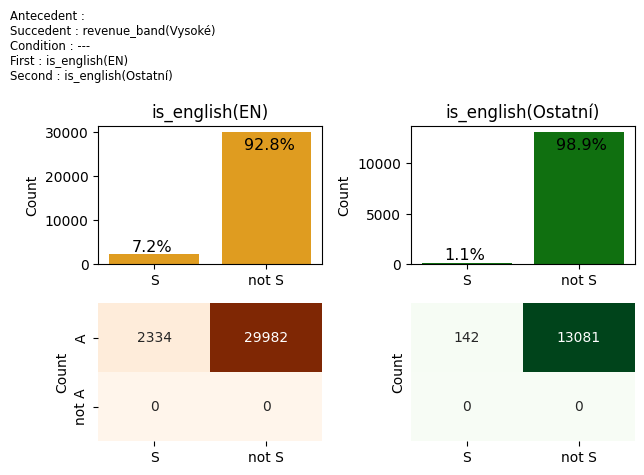

In [7]:
# Nyní máme potvrzeno, že pravidlo má RULEID = 1

RULE_ID_TO_INSPECT = 1 

print(f"--- Detail pravidla {RULE_ID_TO_INSPECT} ---")

try:
    # 1. Znovu vypíšeme textové shrnutí
    miner_task_A.print_rule(RULE_ID_TO_INSPECT)
    
    # 2. Vykreslíme grafy. 
    # OPRAVA: Funkce se volá bez dalších argumentů.
    # Automaticky zobrazí oba porovnávací grafy.
    miner_task_A.draw_rule(RULE_ID_TO_INSPECT)
    
except Exception as e:
    print(f"Chyba při vykreslování pravidla {RULE_ID_TO_INSPECT}: {e}")

## Závěr a Business Interpretace

**Slovní interpretace pravidla:**
Analýza `SD4ftMiner` potvrdila obrovský rozdíl v komerčním potenciálu filmů podle jazyka.

* **Graf pro Skupinu 1 (EN filmy):** Z grafu (a metriky `CONF1`, která je přibližně 0.072) vidíme, že **7.2 %** anglicky mluvených filmů dosáhlo na vysoké tržby.
* **Graf pro Skupinu 2 (Ostatní filmy):** Z grafu (a metriky `CONF2`, která je přibližně 0.011) vidíme, že pouze **1.1 %** filmů v jiných jazycích dosáhlo na vysoké tržby.
* **Metrika `Ratioconf` (6.726)** nám říká, že šance na komerční úspěch (vysoké tržby) je **více než 6.7krát vyšší** u anglicky mluveného filmu.

**Business závěr:**
Data jasně ukazují, že `original_language` = 'en' je dominantním faktorem pro dosažení nejvyšších tržeb. Pro producenta, který cílí na globální komerční úspěch, je volba angličtiny téměř nutností. Filmy v jiných jazycích mají statisticky významně nižší šanci na dosažení nejvyššího pásma tržeb.